In [1]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.models import load_model
from clean import downsample_mono, envelope
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel
from sklearn.preprocessing import LabelEncoder
import numpy as np
from glob import glob
import argparse
import os
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def make_prediction(args):

    model = load_model(args.model_fn,
        custom_objects={'STFT':STFT,
                        'Magnitude':Magnitude,
                        'ApplyFilterbank':ApplyFilterbank,
                        'MagnitudeToDecibel':MagnitudeToDecibel})
    wav_paths = glob('{}/**'.format(args.src_dir), recursive=True)
    wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
    classes = sorted(os.listdir(args.src_dir))
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    le = LabelEncoder()
    y_true = le.fit_transform(labels)
    results = []
    
    fn_prob = {}

    for z, wav_fn in tqdm(enumerate(wav_paths), total=len(wav_paths)):
        rate, wav = downsample_mono(wav_fn, args.sr)
        mask, env = envelope(wav, rate, threshold=args.threshold)
        clean_wav = wav[mask]
        step = int(args.sr*args.dt)
        batch = []

        for i in range(0, clean_wav.shape[0], step):
            sample = clean_wav[i:i+step]
            sample = sample.reshape(-1, 1)
            if sample.shape[0] < step:
                tmp = np.zeros(shape=(step, 1), dtype=np.float32)
                tmp[:sample.shape[0],:] = sample.flatten().reshape(-1, 1)
                sample = tmp
            batch.append(sample)
        X_batch = np.array(batch, dtype=np.float32)
        y_pred = model.predict(X_batch, verbose=0)
        y_predd.append(y_pred)
        y_mean = np.mean(y_pred, axis=0)
        y_pred = np.argmax(y_mean)
        y_predictions.append(y_pred)
        real_class = os.path.dirname(wav_fn).split('/')[-1]
        y_truee.append(classes.index(real_class))
        print('File Name: '+wav_fn, 'Actual class: {}, Predicted class: {}'.format(real_class, classes[y_pred]))
        results.append(y_mean)

    np.save(os.path.join('logs', args.pred_fn), np.array(results))
    return y_truee, y_predictions
    

 
 
if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_fn', type=str, default='models/conv2d.h5',
                        help='model file to make predictions')
    parser.add_argument('--pred_fn', type=str, default='T1',
                        help='fn to write predictions in logs dir')
    parser.add_argument('--src_dir', type=str, default='D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3',
                        help='directory containing wavfiles to predict')
    parser.add_argument('--dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sr', type=int, default=16000,
                        help='sample rate of clean audio')
    parser.add_argument('--threshold', type=str, default=20,
                        help='threshold magnitude for np.int16 dtype')
    args, _ = parser.parse_known_args()

    y_predictions = []
    y_truee = []
    y_predd = []
    make_prediction(args)

    #ACCURACY
    acc_score = accuracy_score(y_true=y_truee, y_pred=y_predictions)
    print(f'Accuracy: {acc_score:.3f}')

    #PRECISION
    precision = precision_score(y_true=y_truee, y_pred=y_predictions, average='micro')
    print(f"Precision: {precision:.3f}")

    #RECALL
    recall = recall_score(y_truee, y_predictions, average='micro')
    print(f"Recall: {recall:.3f}")

    #F1 SCORE
    f1 = f1_score(y_true=y_truee, y_pred=y_predictions, average='micro')
    print(f"F1 Score: {f1:.3f}")

    print(y_truee, len(y_truee))
    print(y_predictions, len(y_predictions))


 20%|██        | 4/20 [00:00<00:01, 13.79it/s]

File Name: D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3/siren/chunk40.wav Actual class: siren, Predicted class: siren
File Name: D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3/siren/chunk41.wav Actual class: siren, Predicted class: siren
File Name: D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3/siren/chunk42.wav Actual class: siren, Predicted class: siren
File Name: D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3/siren/chunk43.wav Actual class: siren, Predicted class: siren
File Name: D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3/siren/chunk44.wav Actual class: siren, Predicted class: siren


 35%|███▌      | 7/20 [00:00<00:00, 13.94it/s]

File Name: D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3/siren/chunk45.wav Actual class: siren, Predicted class: siren
File Name: D:/SirenNeuralNetwork/enhanced-sirenmodel/validation/T3/siren/chunk46.wav Actual class: siren, Predicted class: siren


IndexError: list index out of range

In [38]:
print(y_predd)

[array([[2.2967707e-02, 4.8916815e-03, 4.4241449e-04, 1.5827175e-03,
        2.6896631e-03, 3.7403930e-05, 9.6377879e-01, 1.8086885e-04,
        3.1604627e-03, 2.6837736e-04]], dtype=float32), array([[2.3608295e-04, 2.7531649e-03, 7.0983988e-05, 3.1158523e-04,
        1.3094784e-04, 5.3060643e-04, 9.9445987e-01, 6.0124468e-04,
        7.5580488e-04, 1.4984608e-04]], dtype=float32), array([[0.01421339, 0.00893247, 0.02349885, 0.0095974 , 0.00245038,
        0.00125554, 0.9020512 , 0.02294232, 0.01283829, 0.00222009]],
      dtype=float32), array([[2.7039812e-06, 3.0074449e-07, 6.7890454e-07, 2.5000210e-07,
        1.9442771e-06, 2.2251663e-09, 9.9999344e-01, 4.9066632e-08,
        5.4594705e-07, 1.5581243e-07]], dtype=float32), array([[1.1533301e-07, 2.8294276e-05, 1.4835824e-07, 6.6307912e-08,
        1.1431652e-08, 1.8761611e-07, 9.9997020e-01, 1.1122820e-07,
        8.2741428e-07, 1.0522657e-08]], dtype=float32), array([[1.0359326e-03, 8.6907437e-04, 1.0373669e-03, 8.1286236e-04,
   

In [48]:
print(y_predd[:])

[array([[2.2967707e-02, 4.8916815e-03, 4.4241449e-04, 1.5827175e-03,
        2.6896631e-03, 3.7403930e-05, 9.6377879e-01, 1.8086885e-04,
        3.1604627e-03, 2.6837736e-04]], dtype=float32), array([[2.3608295e-04, 2.7531649e-03, 7.0983988e-05, 3.1158523e-04,
        1.3094784e-04, 5.3060643e-04, 9.9445987e-01, 6.0124468e-04,
        7.5580488e-04, 1.4984608e-04]], dtype=float32), array([[0.01421339, 0.00893247, 0.02349885, 0.0095974 , 0.00245038,
        0.00125554, 0.9020512 , 0.02294232, 0.01283829, 0.00222009]],
      dtype=float32), array([[2.7039812e-06, 3.0074449e-07, 6.7890454e-07, 2.5000210e-07,
        1.9442771e-06, 2.2251663e-09, 9.9999344e-01, 4.9066632e-08,
        5.4594705e-07, 1.5581243e-07]], dtype=float32), array([[1.1533301e-07, 2.8294276e-05, 1.4835824e-07, 6.6307912e-08,
        1.1431652e-08, 1.8761611e-07, 9.9997020e-01, 1.1122820e-07,
        8.2741428e-07, 1.0522657e-08]], dtype=float32), array([[1.0359326e-03, 8.6907437e-04, 1.0373669e-03, 8.1286236e-04,
   

In [25]:
fpr, tpr, thresholds, = roc_curve(y_truee, y_predictions, y_predd)

TypeError: too many positional arguments

In [16]:
cm = confusion_matrix(y_truee, y_predictions)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[18  2]
 [ 0  0]]


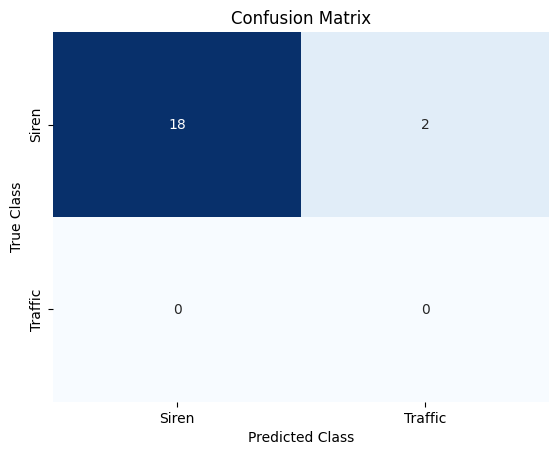

In [49]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Siren', 'Traffic'], yticklabels=['Siren', 'Traffic'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
